<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    FIT-HCMUS, VNU-HCM 
    <br>
    Programing for Data Science
    <br>
    Final project
</div>

# Members

| Student ID | Name             |
|------------|------------------|
| 21127742   | Nguyễn Minh Hiếu |

# Dataset infomation

## What subject is your data about? What is the source of your data?
The data is related to a game called **Valorant**. Valorant is a free-to-play first-person tactical hero shooter developed and published by **Riot Games**, for Windows.
Valorant has an active esports scene. The highest tier of Valorant Esports is run by Riot Games.
**Valorant Champions Tour (VCT)** is a global competitive esports tournament series for the video game Valorant organised by Riot Games, the game's developers. The series runs multiple events throughout each season, culminating in Valorant Champions, the top-level event of the tour. The VCT was announced in 2020, with its inaugural season taking place in 2021.

This dataset contain is about [**Valorant Champions Tour 2023 All Tournaments Stats**](https://www.kaggle.com/datasets/ediashtarevin/vct-champions-2023-stats/data), containing 200 columns and 6000+ rows, stats about team, map and agent of each player.
## Do authors of this data allow you to use like this?
The author of this dataset is [qualidea1217](https://www.kaggle.com/qualidea1217)
The data follows the [**Community Data License Agreement**](https://cdla.dev/sharing-1-0/)
## How did authors collect data?
Data is likely scraped from vlr.gg, one of the three major websites (vlr.gg, rib.gg, thespike.gg) that give out past Valorant pro matches data since there is a [vlrgg scraper](https://www.kaggle.com/code/qualidea1217/vlrgg-scraper) code on his profile.

## Import libraries

In [43]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Exploring data

Read raw data from file

In [44]:
file_path = '../data/player_stats.csv'
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,match_id,game_id,team,score_team,opponent,score_opp,win_lose,map,map_pick,...,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
0,0,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,1.19,239,15,11,6,72%,146,16%,1,0
1,1,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.84,234,15,14,6,61%,145,32%,1,4
2,2,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.68,173,10,15,2,67%,123,18%,4,2
3,3,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.63,142,8,15,4,83%,92,29%,3,2
4,4,53658,119512,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,...,0.57,114,7,16,8,61%,63,13%,0,1


### How many rows and how many columns?

In [45]:
data.shape

(6230, 23)

### What is the meaning of each row?

Each row contains basic statistics of each player and team for each game in all VCT 2023

### Checking duplicates

In [46]:
num_duplicated_rows = data.duplicated(keep='first').sum()

In [47]:
if num_duplicated_rows == 0:
    print(f"No duplicated lines.")
else:
    ext = "lines" if num_duplicated_rows > 1 else "line"
    print(f"{num_duplicated_rows} duplicated {ext}. De-deduplicating the raw data.")

No duplicated lines.


In [48]:
# De-deduplicate
data = data.drop_duplicates(keep='first')
post_deduplication_count = data.duplicated(keep='first').sum()
assert post_deduplication_count == 0, "Still have duplicated rows after de-duplication."

### What is the meaning of each column?

In [49]:
data.columns

Index(['Unnamed: 0', 'match_id', 'game_id', 'team', 'score_team', 'opponent',
       'score_opp', 'win_lose', 'map', 'map_pick', 'player_id', 'player',
       'agent', 'rating', 'acs', 'kill', 'death', 'assist', 'kast%', 'adr',
       'hs%', 'fk', 'fd'],
      dtype='object')

<table style="width: 100%; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="min-width: 10px; width: 30px; background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">STT</th>
      <th style="background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">Cột</th>
      <th style="background-color: #AC94F4; color: white; font-size :15px; font-weight: bold; text-align: left; padding: 8px;">Ý nghĩa</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="font-size: 14px; text-align: left;">1</td>
      <td style="font-size: 14px; text-align: left;">match_id</td>
      <td style="font-size: 14px; text-align: left;">ID of matches played</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">2</td>
      <td style="font-size: 14px; text-align: left;">game_id</td>
      <td style="font-size: 14px; text-align: left;">Game ID of each map played from each match</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">3</td>
      <td style="font-size: 14px; text-align: left;">team</td>
      <td style="font-size: 14px; text-align: left;">Team name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">4</td>
      <td style="font-size: 14px; text-align: left;">score_team</td>
      <td style="font-size: 14px; text-align: left;">Final score achieved by the team</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">5</td>
      <td style="font-size: 14px; text-align: left;">opponent</td>
      <td style="font-size: 14px; text-align: left;">Opponent team name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">6</td>
      <td style="font-size: 14px; text-align: left;">score_opp</td>
      <td style="font-size: 14px; text-align: left;">Final score achieved by the opponent</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">7</td>
      <td style="font-size: 14px; text-align: left;">win_lose</td>
      <td style="font-size: 14px; text-align: left;">Result of the game</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">8</td>
      <td style="font-size: 14px; text-align: left;">map</td>
      <td style="font-size: 14px; text-align: left;">Name of map played</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">9</td>
      <td style="font-size: 14px; text-align: left;">map_pick</td>
      <td style="font-size: 14px; text-align: left;">Which team picked the map</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">10</td>
      <td style="font-size: 14px; text-align: left;">player_id</td>
      <td style="font-size: 14px; text-align: left;">ID of player</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">11</td>
      <td style="font-size: 14px; text-align: left;">player</td>
      <td style="font-size: 14px; text-align: left;">Player name</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">12</td>
      <td style="font-size: 14px; text-align: left;">agent</td>
      <td style="font-size: 14px; text-align: left;">Agent used in the game</td>
    </tr>
    <tr>
      <td style="font-size: 14px; text-align: left;">13</td>
      <td style="font-size: 14px; text-align: left;">rating</td>
      <td style="font-size: 14px; text-align: left;">Rating by player for the game (<a href="https://www.vlr.gg/160667/vlr-gg-player-rating-explained">vlr.gg</a>)</td>
    </tr>
     <tr>
      <td style="font-size: 14px; text-align: left;">14</td>
      <td style="font-size: 14px; text-align: left;">acs</td>
      <td style="font-size: 14px; text-align: left;">Average Combat Score</td>
    </tr>
     <tr>
      <td style="font-size: 14px; text-align: left;">15</td>
      <td style="font-size: 14px; text-align: left;">kill</td>
      <td style="font-size: 14px; text-align: left;">Number of Kill Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">16</td>
      <td style="font-size: 14px; text-align: left;">death</td>
      <td style="font-size: 14px; text-align: left;">Number of Death Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">17</td>
      <td style="font-size: 14px; text-align: left;">assist</td>
      <td style="font-size: 14px; text-align: left;">Number of Assist Accumulated</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">18</td>
      <td style="font-size: 14px; text-align: left;">kast%</td>
      <td style="font-size: 14px; text-align: left;">Percentage of Kill, Assist, Survive, Trade</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">19</td>
      <td style="font-size: 14px; text-align: left;">adr</td>
      <td style="font-size: 14px; text-align: left;">Average damage dealt during a game</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">20</td>
      <td style="font-size: 14px; text-align: left;">hs%</td>
      <td style="font-size: 14px; text-align: left;">Headshot percentage</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">21</td>
      <td style="font-size: 14px; text-align: left;">fk</td>
      <td style="font-size: 14px; text-align: left;">First kill count</td>
    </tr>
      <tr>
      <td style="font-size: 14px; text-align: left;">22</td>
      <td style="font-size: 14px; text-align: left;">fd</td>
      <td style="font-size: 14px; text-align: left;">First death count</td>
    </tr>
  </tbody>
</table>

### Is there any column that isn't needed?

Removing `Unnamed: 0`, `game_id` and `player_id`
- `Unnamed: 0`: index column, not needed
- `game_id`: since `game_id` and `match_id` both represents the id of the match, we only need to keep one
- `player_id`: same for `game_id`, `player` is enough with the existance of `team`

In [50]:
data.drop(columns=['Unnamed: 0', 'game_id', 'player_id'], axis=1, inplace=True)
data.head()

,match_id,team,score_team,opponent,score_opp,win_lose,map,map_pick,player,agent,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
0,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,Laz,sova,1.19,239,15,11,6,72%,146,16%,1,0
1,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,TENNN,killjoy,0.84,234,15,14,6,61%,145,32%,1,4
2,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,Dep,jett,0.68,173,10,15,2,67%,123,18%,4,2
3,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,crow,kayo,0.63,142,8,15,4,83%,92,29%,3,2
4,53658,ZETA,5,DRX,13,opponent win,Ascent,opponent pick,SugarZ3ro,omen,0.57,114,7,16,8,61%,63,13%,0,1


### What is the current data type of each column? Are there columns having inappropriate data types?

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6230 entries, 0 to 6229
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   match_id    6230 non-null   int64 
 1   team        6230 non-null   object
 2   score_team  6230 non-null   int64 
 3   opponent    6230 non-null   object
 4   score_opp   6230 non-null   int64 
 5   win_lose    6230 non-null   object
 6   map         6230 non-null   object
 7   map_pick    6230 non-null   object
 8   player      6230 non-null   object
 9   agent       6230 non-null   object
 10  rating      6230 non-null   object
 11  acs         6230 non-null   object
 12  kill        6230 non-null   int64 
 13  death       6230 non-null   int64 
 14  assist      6230 non-null   int64 
 15  kast%       6230 non-null   object
 16  adr         6230 non-null   object
 17  hs%         6230 non-null   object
 18  fk          6230 non-null   object
 19  fd          6230 non-null   object
dtypes: int64

Need to convert `rating`, `acs`, `kast%`, `adr`, `hs%`, `fk` and `fd` into numerical types.
- For `kast%` and `hs%` we need to remove the % sign and turn it into a fraction (ex 70% is 0.7)

Converting `win_lose` into bool and renaming into `win`, because there is only win or lose, also making it easier for later.
Converting `map_pick` info bool too, same reason.

In [52]:
columns_to_convert = ['rating', 'acs', 'adr', 'fk', 'fd']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
data['kast%'] = pd.to_numeric(data['kast%'].str.rstrip('%'), errors='coerce') / 100
data['hs%'] = pd.to_numeric(data['hs%'].str.rstrip('%'), errors='coerce') / 100

data['win'] = data['win_lose'].map({'team win': True, 'opponent win': False})
data.drop(columns=['win_lose'], inplace=True)
data['map_pick'] = data['map_pick'].map({'team pick': True, 'opponent pick': False})

In [53]:
data.head()

,match_id,team,score_team,opponent,score_opp,map,map_pick,player,agent,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd,win
0,53658,ZETA,5,DRX,13,Ascent,False,Laz,sova,1.19,239.0,15,11,6,0.72,146.0,0.16,1.0,0.0,False
1,53658,ZETA,5,DRX,13,Ascent,False,TENNN,killjoy,0.84,234.0,15,14,6,0.61,145.0,0.32,1.0,4.0,False
2,53658,ZETA,5,DRX,13,Ascent,False,Dep,jett,0.68,173.0,10,15,2,0.67,123.0,0.18,4.0,2.0,False
3,53658,ZETA,5,DRX,13,Ascent,False,crow,kayo,0.63,142.0,8,15,4,0.83,92.0,0.29,3.0,2.0,False
4,53658,ZETA,5,DRX,13,Ascent,False,SugarZ3ro,omen,0.57,114.0,7,16,8,0.61,63.0,0.13,0.0,1.0,False


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6230 entries, 0 to 6229
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   match_id    6230 non-null   int64  
 1   team        6230 non-null   object 
 2   score_team  6230 non-null   int64  
 3   opponent    6230 non-null   object 
 4   score_opp   6230 non-null   int64  
 5   map         6230 non-null   object 
 6   map_pick    6230 non-null   bool   
 7   player      6230 non-null   object 
 8   agent       6230 non-null   object 
 9   rating      6160 non-null   float64
 10  acs         6160 non-null   float64
 11  kill        6230 non-null   int64  
 12  death       6230 non-null   int64  
 13  assist      6230 non-null   int64  
 14  kast%       6160 non-null   float64
 15  adr         6160 non-null   float64
 16  hs%         6160 non-null   float64
 17  fk          6160 non-null   float64
 18  fd          6160 non-null   float64
 19  win         6230 non-null  

### Checking distribution

#### With each numerical column, how are values distributed?

For columns with numeric data types:
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (phân vị 25)
- The median (phân vị 50)
- The upper quartile (phân vị 75)
- The max

For viewing, using `.round(1)`.

In [55]:
def numeric_column_info(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    num_col_info = {}
    for col in numeric_columns:
        num_col_info[col] = [
            df[col].isnull().mean() * 100,  # Missing ratio
            df[col].min(),                  # Min
            df[col].quantile(0.25),         # Lower quartile
            df[col].median(),               # Median
            df[col].quantile(0.75),         # Upper quartile
            df[col].max()                   # Max
        ]

    num_col_info_df = pd.DataFrame(num_col_info, index=["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max"])

    num_col_info_df = num_col_info_df.round(1)

    return num_col_info_df

In [56]:
num_col_info_df = numeric_column_info(data)
num_col_info_df.head()

,match_id,score_team,score_opp,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
missing_ratio,0.0,0.0,0.0,1.1,1.1,0.0,0.0,0.0,1.1,1.1,1.1,1.1,1.1
min,52768.0,0.0,0.0,0.0,36.0,2.0,2.0,0.0,0.1,20.0,0.0,0.0,0.0
lower_quartile,53561.0,8.0,8.0,0.8,158.0,11.0,13.0,4.0,0.6,104.0,0.2,1.0,1.0
median,53699.0,13.0,13.0,1.0,194.0,14.0,15.0,6.0,0.7,127.0,0.2,2.0,2.0
upper_quartile,59969.0,13.0,13.0,1.2,233.0,18.0,17.0,9.0,0.8,153.0,0.3,3.0,3.0


It seems that `rating`, `acs`, `kast%`, `adr`, `hs%`, `fk` and `fd` is missing from some of the matches.
I will check if the values are missing from the same matches, and if yes, i will remove those matches since filling will mess up individual and team performance.

In [57]:
missing_data_columns = ['rating', 'acs', 'kast%', 'adr', 'hs%', 'fk', 'fd']
missing_data = data[missing_data_columns].isnull()
missing_in_all = missing_data.all(axis=1)
matches_with_missing_data = data[missing_in_all]['match_id'].unique()
count_matches_with_missing_data = len(matches_with_missing_data)

if count_matches_with_missing_data > 0:
    data = data[~data['match_id'].isin(matches_with_missing_data)]
else:
    data = data

count_matches_with_missing_data

6

In [58]:
num_col_info_df = numeric_column_info(data)
num_col_info_df.head()

,match_id,score_team,score_opp,rating,acs,kill,death,assist,kast%,adr,hs%,fk,fd
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,52768.0,0.0,0.0,0.0,36.0,2.0,2.0,0.0,0.1,20.0,0.0,0.0,0.0
lower_quartile,53562.0,8.0,8.0,0.8,158.0,11.0,13.0,4.0,0.6,104.0,0.2,1.0,1.0
median,53700.0,13.0,13.0,1.0,194.0,14.0,15.0,6.0,0.7,127.0,0.2,2.0,2.0
upper_quartile,59970.0,13.0,13.0,1.2,233.0,18.0,17.0,9.0,0.8,153.0,0.3,3.0,3.0


A total of 6 matches was removed. Other than that, the data looks fine.

#### With each categorical column, how are values distributed?

For columns with non-numeric data types:
- Percentage (from 0 to 100) of missing values
- Number of values (the values here are different values and we do not consider missing values)
- The percentage (from 0 to 100) of each value is sorted by decreasing percentage (we do not consider missing values, the ratio is the ratio compared to the number of non-missing values)

In [59]:
non_numeric_columns = data.select_dtypes(include=['object', 'bool']).columns

cat_col_info = {}
for col in non_numeric_columns:
    missing_ratio = data[col].isnull().mean() * 100

    num_values = data[col].nunique()

    value_counts = data[col].value_counts(normalize=True) * 100
    value_ratios = value_counts.to_dict()

    cat_col_info[col] = [missing_ratio, num_values, value_ratios]

cat_col_info_df = pd.DataFrame(cat_col_info, index=["missing_ratio", "num_values", "value_ratios"])

cat_col_info_df.loc['missing_ratio'] = cat_col_info_df.loc['missing_ratio'].apply(lambda x: round(x, 1) if isinstance(x, float) else x)

cat_col_info_df

,team,opponent,map,map_pick,player,agent,win
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_values,36,36,8,2,197,21,2
value_ratios,"{'EG': 6.075533661740558, 'PRX': 5.00821018062...","{'EG': 6.075533661740558, 'PRX': 5.00821018062...","{'Ascent': 16.420361247947454, 'Lotus': 16.091...","{False: 57.88177339901478, True: 42.1182266009...","{'Ethan': 1.2151067323481117, 'Boostio': 1.215...","{'killjoy': 12.955665024630541, 'jett': 12.495...","{False: 50.0, True: 50.0}"


Overall, there is no missing value. The data looks fine.

In [60]:
data.columns

Index(['match_id', 'team', 'score_team', 'opponent', 'score_opp', 'map',
       'map_pick', 'player', 'agent', 'rating', 'acs', 'kill', 'death',
       'assist', 'kast%', 'adr', 'hs%', 'fk', 'fd', 'win'],
      dtype='object')

## Asking meaningful questions

### Question 1: How does the choice of an agent affect individual player performance metrics (like ACS, Rating) across different maps?
What is the question?
This question seeks to explore the relationship between the choice of an agent and individual player performance metrics, specifically Average Combat Score (ACS) and Rating, across different maps in Valorant. The analysis will compare how players' performances vary when they select different agents on various maps.

Benefits of finding the answer:
Strategic Insights for Teams and Players: Understanding the impact of agent choice on performance metrics like ACS and Rating on different maps can provide valuable insights for teams and players in terms of strategy formulation. It helps in identifying which agents are more effective on specific maps and how players can maximize their impact.

Agent Balancing for Game Developers: This analysis can provide feedback to game developers about the balance between different agents across various maps. If certain agents consistently lead to higher performance metrics on specific maps, it might indicate a need for balancing adjustments.

Fan Engagement and Analysis: Fans and analysts of Valorant can use this information for deeper engagement with the game, discussing strategies and performance.

Preprocessing Steps:
Group Data: Group the dataset by 'map' and 'agent' to analyze the performance metrics for each agent on each map.
Calculate Metrics: Calculate the average values of performance metrics (ACS and Rating) for each agent-map combination.
Preprocessing Implementation (Sketch):
Utilize groupby function in pandas to group data by 'map' and 'agent'.
Calculate the mean of 'ACS' and 'Rating' for these groups.
Data Analysis to Answer the Question:
Visualization: Create bar plots to visualize the average ACS and Rating for each agent on each map.
Interpretation: By comparing these metrics across different maps and agents, identify patterns or notable differences in performance.
Code for Preprocessing and Analysis:

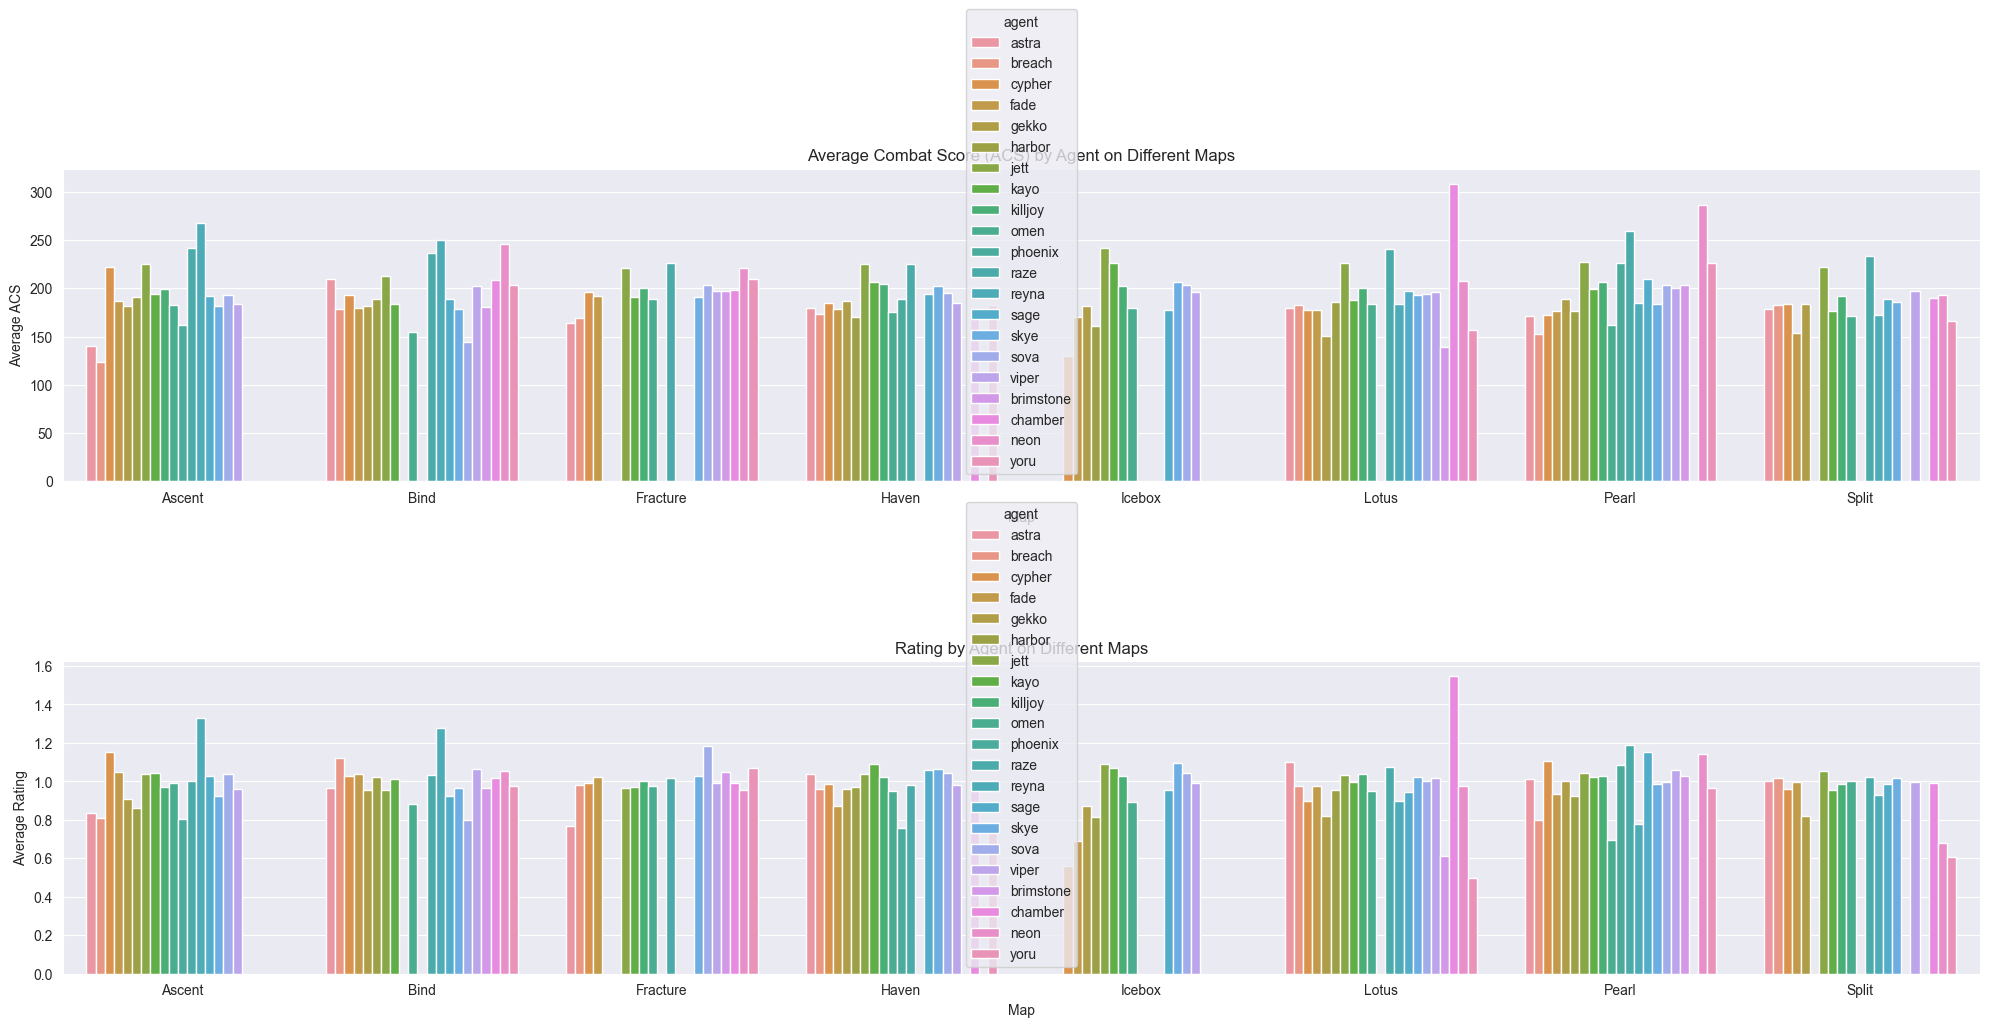

In [61]:
# Grouping data by map, agent and calculating the mean of ACS and Rating
agent_performance = data.groupby(['map', 'agent'])[['acs', 'rating']].mean().reset_index()

# Plotting the results
plt.figure(figsize=(20, 10))

# ACS Performance
plt.subplot(2, 1, 1)
sns.barplot(x='map', y='acs', hue='agent', data=agent_performance)
plt.title('Average Combat Score (ACS) by Agent on Different Maps')
plt.ylabel('Average ACS')
plt.xlabel('Map')

# Rating Performance
plt.subplot(2, 1, 2)
sns.barplot(x='map', y='rating', hue='agent', data=agent_performance)
plt.title('Rating by Agent on Different Maps')
plt.ylabel('Average Rating')
plt.xlabel('Map')

plt.tight_layout()
plt.show()

### Question 2: What is the agent pick rate per map, and does it affect the win rate?

This question aims to analyze the frequency at which different agents are chosen (pick rate) on each map and investigate whether there's a correlation between the choice of agent and the win rate of the team on those maps.

- Benefits of finding the answer:
    - Team Composition and Strategy: By understanding which agents are more frequently picked on specific maps and how this correlates with winning, teams can optimize their compositions and strategies for different maps.
    - Game Balance and Design: This analysis can inform game developers about potential issues in map or agent design. If certain agents have a significantly higher win rate on certain maps, it might suggest that those agents are overly effective or that the maps favor certain playstyles.
    - E-Sports and Competitive Insights: For the competitive scene, this analysis is crucial in understanding the meta-game. Teams and coaches can use this data to prepare for tournaments by understanding current trends in agent selection and effectiveness.

#### Preprocessing
Calculate Pick Rate: Determine how often each agent is picked on each map.
Calculate Win Rate: Compute the win rate for each agent on each map.
Preprocessing Implementation (Sketch):
Group data by 'map' and 'agent' and count occurrences to find pick rates.
For win rates, calculate the mean of the 'win' column for each agent-map group.
Data Analysis to Answer the Question:
Visualization: Use heatmaps to display the pick rate and win rate of each agent on each map.
Correlation Analysis: Observe if there’s a correlation between high pick rates and high win rates for agents on specific maps.
Code for Preprocessing and Analysis:

#### Analysis

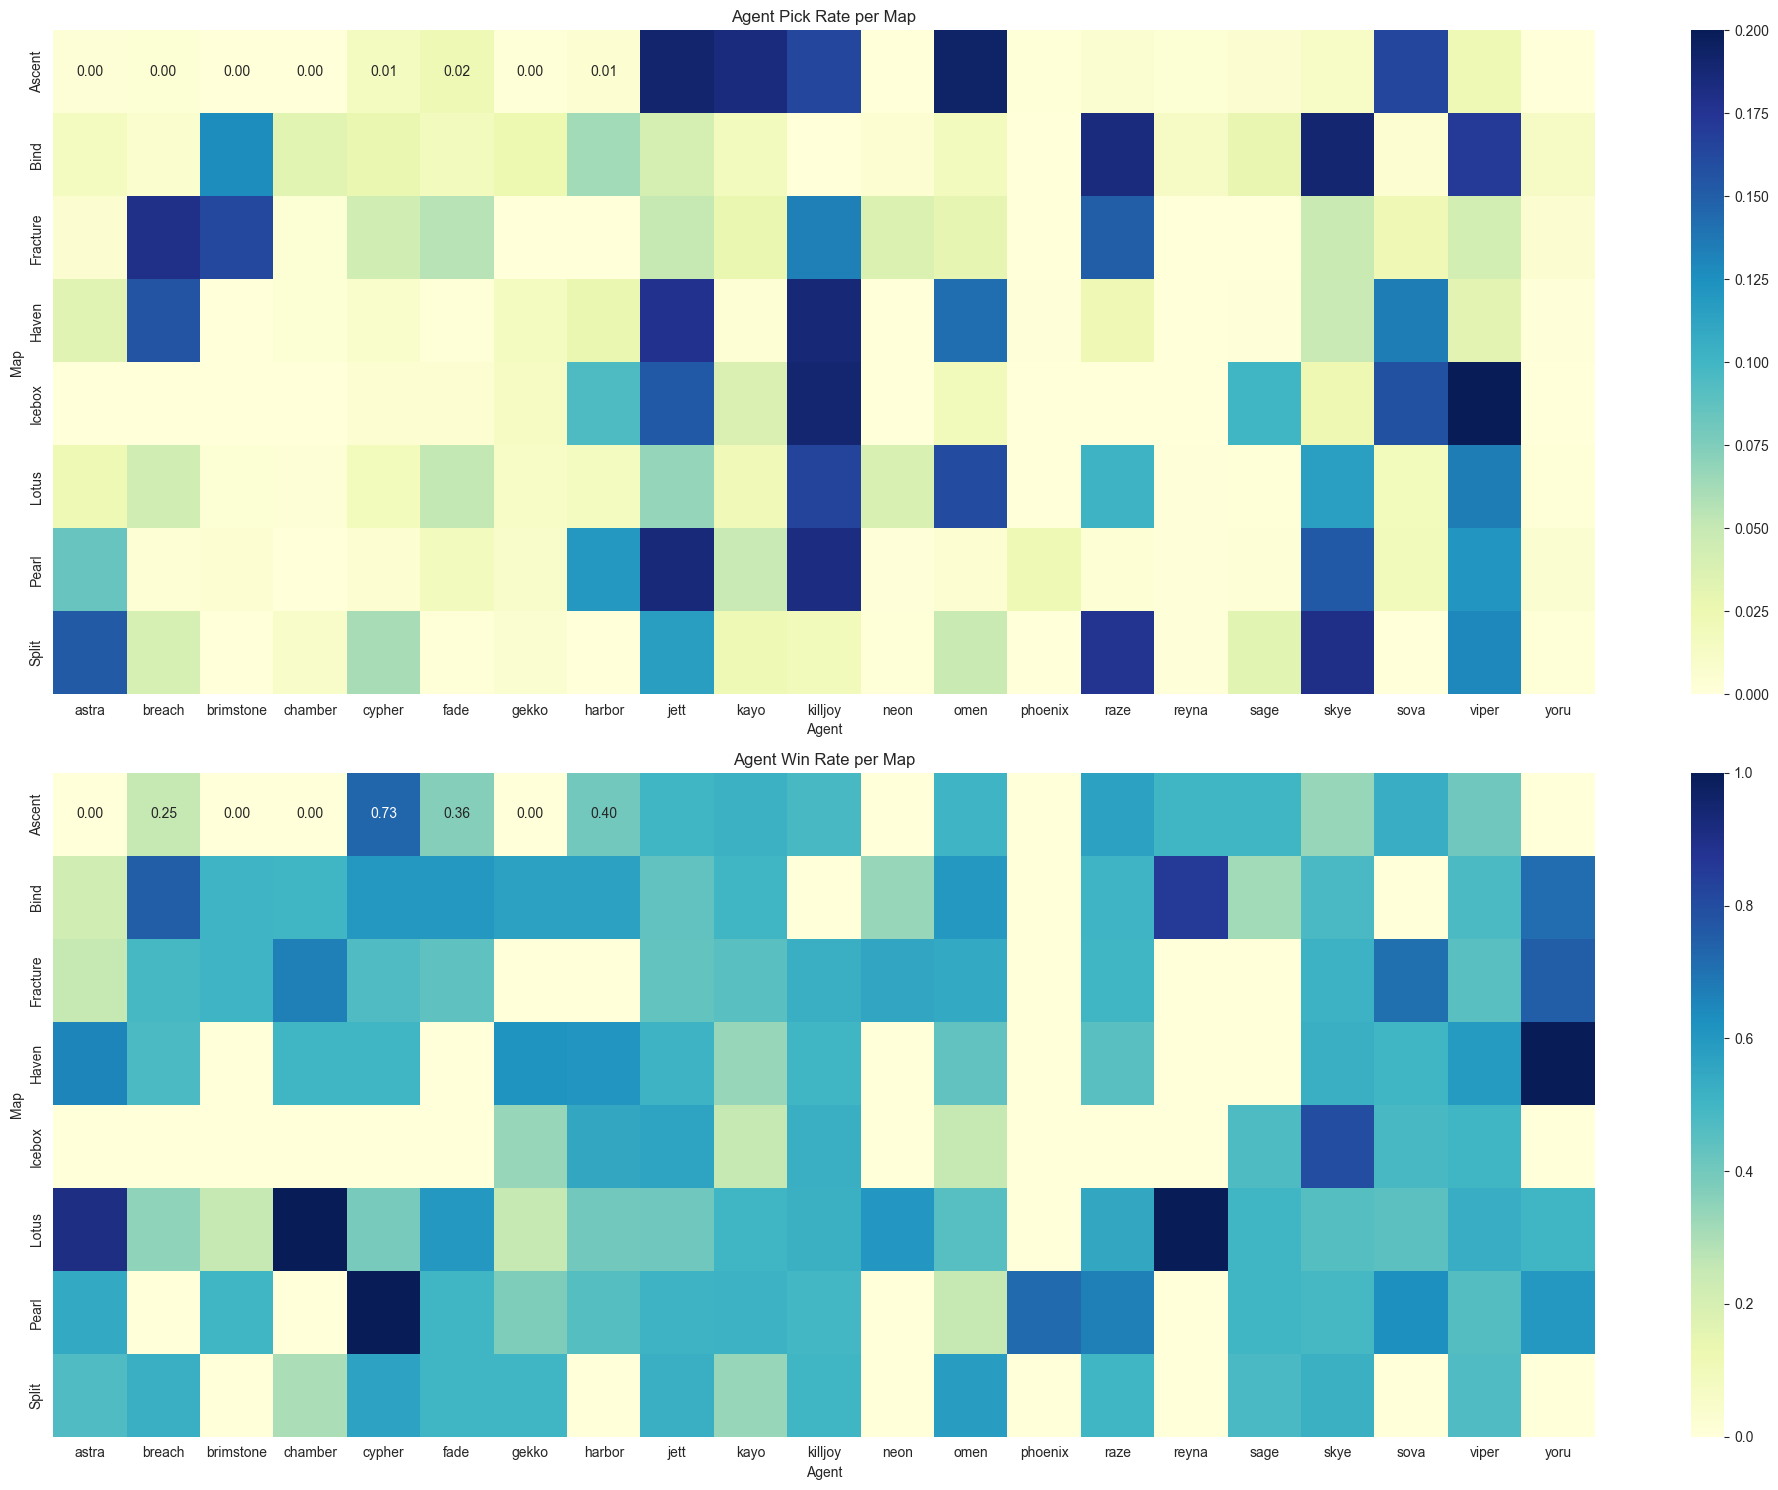

In [62]:
# Calculating the pick rate of each agent on each map
agent_pick_rate = data.groupby(['map', 'agent']).size().unstack(fill_value=0)
total_picks_per_map = agent_pick_rate.sum(axis=1)
agent_pick_rate = agent_pick_rate.divide(total_picks_per_map, axis=0)

# Calculating the win rate of each agent on each map
agent_win_rate = data.groupby(['map', 'agent'])['win'].mean().unstack(fill_value=0)

# Visualizing the results
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

# Agent Pick Rate per Map
sns.heatmap(agent_pick_rate, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Agent Pick Rate per Map')
axes[0].set_xlabel('Agent')
axes[0].set_ylabel('Map')

# Agent Win Rate per Map
sns.heatmap(agent_win_rate, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Agent Win Rate per Map')
axes[1].set_xlabel('Agent')
axes[1].set_ylabel('Map')

plt.tight_layout()
plt.show()

### Question 3: Can we predict the outcome of a Valorant game (win or lose) based on player and team performance metrics?
Benefits of Finding the Answer:
Strategic Planning for Teams: Understanding key factors that contribute to winning can help teams focus on improving specific aspects of their gameplay.
Analytical Insight for Coaches and Analysts: Coaches can use the model's insights to refine training and strategies.
Betting and Prediction Markets: Accurate predictions can be valuable for betting markets and fans interested in game outcomes.
Preprocessing Steps:
Feature Selection: Identify relevant features that could influence the game outcome, such as ACS, Rating, K/D ratio, etc.
Handling Missing Values: Deal with any missing values in these features, either by imputation or removal.
Data Normalization: Normalize the features to ensure they are on a similar scale, important for many machine learning algorithms.
Encoding Categorical Variables: Convert categorical variables like 'map' and 'agent' into a format that can be used in modeling, such as one-hot encoding.
Preprocessing Implementation (Sketch):
Select relevant columns for the model.
Check for missing values and handle them appropriately.
Use a scaler (like MinMaxScaler or StandardScaler) to normalize numerical features.
Apply one-hot encoding to categorical features.
Data Modeling to Answer the Question:
Model Selection: Choose an appropriate classification model, like Logistic Regression, Random Forest, or Gradient Boosting.
Train-Test Split: Split the data into training and testing sets to evaluate the model's performance.
Model Training: Train the model on the training set.
Model Evaluation: Evaluate the model on the test set using metrics like accuracy, precision, recall, and ROC-AUC.

In [63]:
# Feature selection - selecting a subset of features for the model
feature_columns = ['acs', 'rating', 'kill', 'death', 'assist', 'kast%', 'adr', 'hs%', 'fk', 'fd', 'map', 'agent']
X = data[feature_columns]
y = data['win']

# Handling missing values - imputation
imputer = SimpleImputer(strategy='mean')

# Data normalization and encoding categorical variables
numerical_cols = ['acs', 'rating', 'kill', 'death', 'assist', 'kast%', 'adr', 'hs%', 'fk', 'fd']
categorical_cols = ['map', 'agent']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Creating a pipeline with preprocessing and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.79584017515052,
 '              precision    recall  f1-score   support\n\n       False       0.79      0.80      0.80       915\n        True       0.80      0.79      0.79       912\n\n    accuracy                           0.80      1827\n   macro avg       0.80      0.80      0.80      1827\nweighted avg       0.80      0.80      0.80      1827\n')